# Imports

In [1]:
# Imports
from requests import get
from pandas import DataFrame, concat
from html.parser import HTMLParser
from re import compile, DOTALL
from matplotlib.pyplot import figure, bar, subplots
from seaborn import heatmap

# NLTK Imports
from nltk import bigrams, FreqDist, download
from nltk.tokenize import sent_tokenize, RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
download("wordnet")
download("omw-1.4")
download("punkt")
download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Activity 3

# 3.1 Sub-activity: Loading and pre-processing of text data

## Task 1

In [2]:
# The Google Python Style Guide has been followed throughout each task.
# 

def get_turing_award_recipients():
    """Returns a list of WikiData entities of humans which won the
        ACM Turing Award.

    Returns:
        (list of dictionaries): Recipient entities.
    """
    # Uses a WikiData SPARQL query to retrieve Turing Award recipients.
    url = "https://query.wikidata.org/sparql"
    query = """
    SELECT DISTINCT ?item ?itemLabel ?itemDescription
    WHERE {
        ?item wdt:P166 wd:Q185667;    
        SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }
    }
    """
    req = get(url, params = {"format": "json", "query": query})
    return req.json()["results"]["bindings"]

recipients = get_turing_award_recipients()

## Task 2

In [3]:
# This code segment declares the "get_wikipedia_content" method. The next code
# segment (task 3) is where all of the Wikipedia page content for all recipients
# is retrieved using this method.
#

def get_wikipedia_content(id):
    """Returns the content of the English Wikipedia page for a given "id".

    Args:
        id (string): ID of the WikiData entity for which to download its 
            Wikipedia page.

    Returns:
        req (dictionary): WikiData data about a given entity.
        page_data (string): Wikipedia page data about a given entity.
    """
    # Makes a request to download data for a specific WikiData entity by
    # its "id". More specifically, downloads all of that entities labels, 
    # descriptions, and claims in English in JSON format.
    url = "https://www.wikidata.org/w/api.php?"
    params = {
        "action": "wbgetentities",
        "format": "json",
        "languages": "en",
        "sites": "enwiki",
        "ids": id,
        "props": "labels|descriptions|claims"
    }
    req = get(url, params = params).json()["entities"][id]
    # Retrieves the name of the recipient from the downloaded data.
    name = req["labels"]["en"]["value"]
    # Downloads the recipients Wikipedia page data in HTML format using their
    # name to construct the URL.
    name = name.replace(" ", "_")
    response = get(url="https://en.wikipedia.org/wiki/" + name)

    # Attempts to filter the downloaded HTML data of its tags, only to return
    # the actual page's text.
    global page_data
    page_data = ""
    class MyHTMLParser(HTMLParser):
        """A simple HTML parser class that inherits the HTMLParser class and 
            prints out any data that is encountered.
            
            Note: this class was taken and modified from:
            https://docs.python.org/3/library/html.parser.html
        """        
        # def handle_starttag(self, tag, attrs):
        #     print("Encountered a start tag:", tag)
        # def handle_endtag(self, tag):
        #     print("Encountered an end tag :", tag)
        def handle_data(self, data):
            """Processes any data encountered in the text.

            Args:
                data (string): A piece of text found between tags from a HTML
                    document.
            """
            global page_data
            page_data += data

    parser = MyHTMLParser()
    parser.feed(response.text)
    return req, page_data

# Examples of how to use "get_wikipedia_content" method:
# req, page_data = get_wikipedia_content("Q62857")
# req, page_data = get_wikipedia_content("Q204815")

## Task 3

In [4]:
# Note: this task takes around 3 mins to run on my machine. It does work.
#

def get_details(req, page_data):
    """Filters an entities information to produce a list of that entities 
        characteristics and Wikipedia introduction.

    Args:
        req (dictionary): WikiData data about a given entity.
        page_data (string): Wikipedia page data about a given entity.

    Returns:
        (list): A list consisting of a given recipients name, Wikipedia
            introduction, gender, birth date, birth place, and a list
            of their employers and educational institutions, respectively.
    """ 
    # Initially processes the entities data.
    try:  # Tries to retrieve the entities full name if one exists.   
        name = req["claims"]["P1559"][0]["mainsnak"]["datavalue"]["value"]["text"]
        # If the full name is not in English, raise an exception.
        if not name.isascii(): raise Exception()  
    # If the WikiData entity does not store a full name or the name is not in
    # English.
    except:
        # Tries to retrieve the entities name if it exists.
        try: name = req["labels"]["en"]["value"]
        except: name = None  # If no name was found.
        
    try: # Tries to retrieve the birth date of the entity if one exists.
        birth_date = req["claims"]["P569"][0]["mainsnak"]["datavalue"]["value"]["time"]
    except: birth_date = None  # If no birth date was found.
    
    try:  # Tries to retrieve the entities gender if one exists.
        # Wikidata entities store gender using an ID. Retrieves this ID.
        gender_id = req["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]
        if gender_id == "Q6581097":  # If the recipient is male.
            gender = "male"
        elif gender_id == "Q6581072":  # Else if the recipient is female.
            gender = "female"
        else:  # Else, set gender to "other".
            gender = "other"
    except: gender = None  # If no gender was found.
    
    try:  # Tries to retrieve the entities birth place if one exists.
        # Birth places are also stored using IDs. Retrieves this ID.
        birth_place_id = req["claims"]["P19"][0]["mainsnak"]["datavalue"]["value"]["id"]
        params = {
            "action": "wbgetentities",
            "format": "json",
            "languages": "en",
            "sites": "enwiki",
            "ids": birth_place_id,
            "props": "labels"
        }
        # Requests the labels of a location based on its ID. Stores the name of
        # the birth place.
        birth_place = get("https://www.wikidata.org/w/api.php?",
                          params=params).json()["entities"][
                            birth_place_id]["labels"]["en"]["value"]
    except: birth_place = None  # If no birth place was found.
    
    try:  # Tries to retrieve the entities employers if they exist.
        employer_ids = []
        employers = []
        # For each employer of the entity.
        for employer in req["claims"]["P108"]:
            # Save that employers ID to the "employer_ids" list.
            employer_ids.append(employer["mainsnak"]["datavalue"]["value"]["id"])
        for employer_id in employer_ids:  # For each employer ID.
            params = {
                "action": "wbgetentities",
                "format": "json",
                "languages": "en",
                "sites": "enwiki",
                "ids": employer_id,
                "props": "labels"
            }
            # Requests and stores the name of that employer based of their ID.
            employers.append(get("https://www.wikidata.org/w/api.php?",
                                 params=params).json()["entities"][
                                     employer_id]["labels"]["en"]["value"])
    except: employers = None  # If no employers were found.
    
    try:  # Tries to retrieve the entities educational institutions if they exist.
        educated_at_ids = []
        educated_at = []
        # For each educational institution of the entity.
        for school in req["claims"]["P69"]:  
            # Save that schools ID to the "educated_at_ids" list.
            educated_at_ids.append(school["mainsnak"]["datavalue"]["value"]["id"])
        for educated_at_id in educated_at_ids:  # For each schools ID.
            params = {
                "action": "wbgetentities",
                "format": "json",
                "languages": "en",
                "sites": "enwiki",
                "ids": educated_at_id,
                "props": "labels"
            }
            # Requests and stores the name of that school based of their ID.
            educated_at.append(get("https://www.wikidata.org/w/api.php?",
                                   params=params).json()["entities"][
                                       educated_at_id]["labels"]["en"]["value"])
    except: educated_at = None  # If no educational institutions were found.
    
    # Processes the entities Wikipedia introduction. Filters the pages data to
    # only return the introduction using regular expressions.
    page_data_stripped = page_data.strip()
    name_list = name.split()
    regex_name = r""
    for word in name_list:
        regex_name += word + r".{,20}?"
    # Different Wikipedia articles have different words preceding their
    # introduction paragraphs. Some articles have the word "Website" followed by
    # the entities website. Some articles have the word "Born" right before
    # the start of the introduction. Both of these words, as well as the 
    # recipients name, have been used in the following regular expression
    # matchers to try and isolate the introduction paragraphs from the rest
    # of the pages data.
    # If the page data contains the word "Website".
    if "Website" in page_data_stripped:  
        # Uses regular expressions to try and isolate the introduction.
        pattern = compile(r"Website.*" + regex_name + r".*\bContents\b", DOTALL)
        intro = pattern.search(page_data_stripped)
        if intro:  # If "intro" exists.
            # Returns the matched introduction section from the regular
            # expression matcher up to the word "Contents". 
            intro = intro.group()
            # Finds and splices the introduction with everything after the word
            # "Website".
            pattern2 = compile(r"Website.*")
            splice_from = pattern2.search(intro).span()[1]
            intro = intro[splice_from:]
    # Else if the page data contains the word "Born".
    elif "Born" in page_data_stripped:
        # Uses regular expressions to try and isolate the introduction.
        pattern = compile(r"Born.*" + regex_name + r".*\bContents\b", DOTALL)
        intro = pattern.search(page_data_stripped)
        if intro:  # If "intro" exists.
            # Returns the matched introduction section from the regular
            # expression matcher.
            intro = intro.group()
            # Finds and splices the introduction with everything after the word
            # "Born".
            pattern2 = compile(r"Born.*")
            splice_from = pattern2.search(intro).span()[1]
            intro = intro[splice_from:]
    else:  # Else, try and use the recipients name. 
        pattern = compile(regex_name + r".*\bContents\b", DOTALL)
        intro = pattern.search(page_data_stripped)
        # If "intro" exists, returns the matched introduction section from the
        # regular expression matcher up to the word "Contents".
        if intro: intro = intro.group()
            
    if intro:  # If "intro" exists.
        # Removes the word "Contents" from the introduction.
        intro = intro[:-8].rstrip()
        # If the last character in the introduction is a new line, remove it.
        if intro[:1] == "\n": intro = intro[1:]
    
    return [name, intro, gender, birth_date,
            birth_place, employers, educated_at]

def get_all_details(recipients):
    """Iterates through each recipient in the "recipients" list and calls the
        "get_wikipedia_content" and "get_details" methods on each recipient.
        Returns each entities details as one dictionary.

    Args:
        recipients (_type_): _description_

    Returns:
        (dictionary): Keys: entry names specified in the question.
            Values: List with each item in the list belonging to a separate
            recipient. 
    """    
    recipient_ids = []
    for recipient in recipients:  # For each recipient. 
        # Get that recipients ID from its data.
        id = ""
        # For each character in the recipients WikiData URL reversed.
        for char in recipient["item"]["value"][::-1]:  
            # Add the character to the "id" if we have not reached the "/"
            # character.
            if char != "/": id += char
            else: break
        # Adds the recipients id to the "recipient_ids" list. This ID needs to 
        # be reversed as when processing the URL, we also reversed the URL.
        recipient_ids.append(id[::-1])

    # Dictionary that will hold all of the data about the award winners.
    award_winners = {"name": [], "intro": [],
                     "gender": [], "birth_date": [],
                     "birth_place": [], "employer": [],
                     "educated_at": []}
    for id in recipient_ids:  # For each recipients ID.
        # Gets the recipients WikiData data and Wikipedia page data using the
        # "get_wikipedia_content" method.
        req, page_data = get_wikipedia_content(id)
        # Processes this data using the "get_details" method.
        details = get_details(req, page_data)
        counter = 0
        # For each entry in the dictionary.
        for key, value in award_winners.items():  
            # Adds the respective value to the dictionary.
            value.append(details[counter])
            counter += 1
    
    return award_winners

award_winners = get_all_details(recipients)

## Task 4

In [5]:
print("Names of all of the award winners in alphabetical order:")
print(sorted(award_winners["name"]))

Names of all of the award winners in alphabetical order:
['Adi Shamir', 'Alan Jay Perlis', 'Alan Kay', 'Alfred Aho', 'Allen Newell', 'Amir Pnueli', 'Andrew Yao', "Bailey Whitfield 'Whit' Diffie", 'Barbara Liskov', 'Bob Kahn', 'Butler W. Lampson', 'Charles Antony Richard Hoare', 'Charles Bachman', 'Charles P. Thacker', 'Dana Stewart Scott', 'David A. Patterson', 'Dennis M. Ritchie', 'Donald Ervin Knuth', 'Douglas Carl Engelbart', 'E. Allen Emerson', 'Edgar Frank Codd', 'Edmund Melson Clarke, Jr.', 'Edsger Wybe Dijkstra', 'Edward Albert Feigenbaum', 'Edwin Catmull', 'Fernando J. Corbató', 'Frances Elizabeth Allen', 'Fred Brooks', 'Geoffrey Hinton', 'Herbert A. S', 'Iosif Sifakis', 'Ivan Sutherland', 'Jack Dongarra', 'James H. Wilkinson', 'James Nicholas "Jim" Gray', 'Jeffrey David Ullman', 'John Backus', 'John Cocke', 'John Edward Hopcroft', 'John L. Hennessy', 'John McCarthy', 'Judea Pearl', 'Juris Hartmanis', 'Kenneth Eugene Iverson', 'Kenneth Lane Thompson', 'Kristen Nygaard', 'Leonar

## Task 5

In [6]:
# Note: Some of the Wikipedia page data introductions have not been processed
# correctly (with some of the HTML left in). As a result, some of the statistics
# and their graphs (eg count_paragraphs) are going to be skewed. If the 
# introduction text had been downloaded correctly, then I believe that these
# statistical methods would work properly.
#

#
# (a)
#

col_names = ["winner_name", "count_words", "count_sentences",
             "count_paragraphs", "common_words",
             "common_words_after_preprocessing"]
award_winners_intro = DataFrame(columns=col_names)

#
# (b) and (c)
#

# Lists that information is appended to for each recipient.
winner_names = []
count_words = []
count_sentences = []
count_paragraphs = []
common_words = []
common_words_after_preprocessing = []

counter = 0
while counter < len(award_winners["name"]):  # Iterates through each recipient.
    # Adds the recipient's name to the "winner_names".
    winner_names.append(award_winners["name"][counter])
    # Saves the recipient's introduction to "intro".
    intro = award_winners["intro"][counter]
    if intro:  # If the introduction exists.
        # Tokenize the introduction, filtering it to only keep English letters.
        tokenized = RegexpTokenizer(r"[a-zA-Z]+").tokenize(intro)
        # Appends the number of words in the paragraph to "count_words".
        count_words.append(len(tokenized))        
        # Uses NLTK's "sent_tokenize" method to count the number of sentences.
        # Appends this to "count_sentences".
        count_sentences.append(len(sent_tokenize(intro)))
        # Counts the number of paragraphs in the introduction by counting the 
        # number of newlines and adding 1. Appends this to "count_paragraphs".
        count_paragraphs.append(intro.count("\n") + 1)
        # A list to store the most common words in the current introduction. 
        current_common_words = []
        # Finds the most common words in the introduction. For each of the 
        # (word, word's frequency in the introduction) tuples.
        for word_tuple in FreqDist(tokenized).most_common():
            # Appends the word to "current_common_words".
            current_common_words.append(word_tuple[0])
        # Appends the 10 most common words to "common_words".
        common_words.append(current_common_words[:10])
        # Appends the 10 most common words to "common_words_after_preprocessing"
        # given that they are not stop words.
        common_words_after_preprocessing.append([
            w for w in current_common_words if not w in list(
                stopwords.words("english"))][:10])
    # Else, assume the introduction is empty and append zeros and empty lists.
    else:
        count_words.append(0)
        count_sentences.append(0)
        count_paragraphs.append(0)
        common_words.append([])
        common_words_after_preprocessing.append([])
    counter += 1
# Adds the calculated statistics to the "award_winners_intro" DataFrame.
temp_dict = {"winner_name": winner_names, "count_words": count_words,
             "count_sentences": count_sentences,
             "count_paragraphs": count_paragraphs, "common_words": common_words,
             "common_words_after_preprocessing": common_words_after_preprocessing}
award_winners_intro = concat([award_winners_intro, DataFrame(temp_dict)])

print("First 10 rows of the dataframe \"award_winners_intro\":")
print(award_winners_intro.head(10))

First 10 rows of the dataframe "award_winners_intro":
                 winner_name count_words count_sentences count_paragraphs  \
0             Maurice Wilkes          71               2                1   
1        Robert Endre Tarjan          63               4                1   
2            Tim Berners-Lee         368              18                4   
3          Butler W. Lampson          25               1                1   
4              William Kahan          41               2                3   
5            Ivan Sutherland         146               7                2   
6            Alan Jay Perlis          41               3                2   
7  Edmund Melson Clarke, Jr.          54               3                1   
8           Edgar Frank Codd          62               3                2   
9                  Raj Reddy         171               6                9   

                                        common_words  \
0  [the, of, a, Wilkes, was, who, and, sto

# 3.2 Sub-activity: Applying NLP operations on the corpus

## 3.2.1 Stemming

## Task 3

In [7]:
#
# (a)
#

def remove_punctuation(text):
    """Removes punctuation and numbers from a "text".

    Args:
        text (string or None): Text to be cleaned.

    Returns:
        (string or None): "text" with everything except English letters
            filtered.
    """    
    # If the "text" is not empty, use NLTK's regular expression tokenizer to 
    # filter the "text" for only English letter and tokenize it.
    if text: return " ".join(RegexpTokenizer(r"[a-zA-Z]+").tokenize(text))
    else: return None
    
def remove_stopwords(text):
    """Removes stop words from a "text".

    Args:
        text (string or None): Text to be filtered for stop words.

    Returns:
        (string or None): "text" with stop words removed.
    """    
    new_text = []
    if text:  # If "text" exists.
        for word in text.split():  # For each word in the text.
            # If the current word is not a stop word (based on NLTK's
            # stop words list).
            if not word in stopwords.words("english"):  
                # Adds the current word to "new_text".
                new_text.append(word)
        # Returns the filtered text (or None if all of the words were stop words).
        if new_text == []: return None
        else: return " ".join(new_text)
    else: return None

# Applies "remove_punctuation" and "remove_stopwords" methods to the
# introductions, saves the results as new columns in the "intro_df" DataFrame.
intro_df = DataFrame(award_winners)
intro_df["no_punctuation"] = intro_df["intro"].apply(remove_punctuation)
intro_df["no_stopwords"] = intro_df["no_punctuation"].apply(remove_stopwords)
intro_words = intro_df["no_stopwords"].to_list()

#
# (b)
#

def calculate_unique_words(text_list):
    """Produces a list of all of the unique words found within texts from the 
        "text_list".

    Args:
        text_list (list of strings): List of texts.

    Returns:
        (list): List of all of the words found within the "text_list" with no
            duplicates.
    """
    unique_words = []
    for text in text_list:  # For each of the texts.
        if text:  # If the "text" exists.
            for word in word_tokenize(text):  # For each word in the "text".
                # If the word has not been added to "unique_words", add it.
                if word not in unique_words:  
                    unique_words.append(word)
    return unique_words

unique_words = calculate_unique_words(intro_words)
print("Number of unique words:", len(unique_words))

#
# (c)
# 

# Uses NLTK's "PorterStemmer" to stem each word in "unique_words".
stemmed_words = [PorterStemmer().stem(word) for word in unique_words]
unique_porter_words = calculate_unique_words(stemmed_words)
print("Number of unique Porter stemmed words:", len(unique_porter_words))


Number of unique words: 1990
Number of unique Porter stemmed words: 1643


## Task 4

In [8]:
# Note: This task uses the "calculate_unique_words" method declared in Task 3.
#

# Uses NLTK's "SnowballStemmer" to stem each word in "unique_words".
stemmed_words = [SnowballStemmer("english").stem(word) for word in unique_words]
unique_snowball_words = calculate_unique_words(stemmed_words)
print("Number of unique Snowball stemmed words:", len(unique_snowball_words))


Number of unique Snowball stemmed words: 1639


## 3.2.2 Lemmatization

## Task 5

In [9]:
# Note: This task uses the "calculate_unique_words" method declared in Task 3.
#

print("Number of unique words:", len(unique_words))
# Uses NLTK's "WordNetLemmatizer" to lemmatize each word.
lemmatized_words = [WordNetLemmatizer().lemmatize(word) for word in unique_words]
unique_lemma_words = calculate_unique_words(lemmatized_words)
print("Number of unique lemmatized words:", len(unique_lemma_words))

Number of unique words: 1990
Number of unique lemmatized words: 1939


## 3.2.3 Finding synonyms and antonyms

## Task 6

In [10]:
#
# (a) and (b)
#

def get_synonyms(text):
    """Produces a list of synonyms found within a text.

    Args:
        text (list of strings): A piece of text that has been tokenized.

    Returns:
        (list of strings): A list of all of the synonyms found within the text 
            with the duplicate words removed.
    """
    unique_synonyms = []
    for word in text:  # For each word in the "text".
        # For each synonym set relating to the "word".
        for synset in wordnet.synsets(word):
            # Retrieves the synonym from the synonym set.
            synonym = synset.name().partition(".")[0]
            # If the "synonym" is not already in the list, add it.
            if synonym not in unique_synonyms:
                unique_synonyms.append(synonym)
    return unique_synonyms

# Applies "get_synonyms" method to the common words, saves these synonyms in a
# new column "synonyms" in the "award_winners_intro" DataFrame.
award_winners_intro["synonyms"] = award_winners_intro[
    "common_words_after_preprocessing"].apply(get_synonyms)

#
# (a) and (c)
#

def get_antonyms(text):
    """Produces a list of antonyms found within a text.

    Args:
        text (list of strings): A piece of text that has been tokenized.

    Returns:
        (list of strings): A list of all of the antonyms found within the text 
            with the duplicate words removed.
    """
    unique_antonyms = []
    for word in text:  # For each word in the "text".
        # For each synonym set relating to the "word".
        for synset in wordnet.synsets(word):
            # For each lemmatized word in the synonym set.
            for lemma in synset.lemmas():
                # Retrieves a list of antonyms relating to the current "lemma".
                antonyms = lemma.antonyms()
                if antonyms:  # If the "lemma" has any antonyms.
                    for antonym in antonyms:  # For each antonym.
                        # If the "antonym" is not already in the list, add it.
                        if antonym.name() not in unique_antonyms:
                            unique_antonyms.append(antonym.name())
    return unique_antonyms

# Applies "get_antonyms" method to the common words, saves these synonyms in a
# new column "antonyms" in the "award_winners_intro" DataFrame.
award_winners_intro["antonyms"] = award_winners_intro[
    "common_words_after_preprocessing"].apply(get_antonyms)

#
# (d)
#

print("First 10 rows of the \"award_winners_intro\" dataframe.")
print(award_winners_intro.head(10))

First 10 rows of the "award_winners_intro" dataframe.
                 winner_name count_words count_sentences count_paragraphs  \
0             Maurice Wilkes          71               2                1   
1        Robert Endre Tarjan          63               4                1   
2            Tim Berners-Lee         368              18                4   
3          Butler W. Lampson          25               1                1   
4              William Kahan          41               2                3   
5            Ivan Sutherland         146               7                2   
6            Alan Jay Perlis          41               3                2   
7  Edmund Melson Clarke, Jr.          54               3                1   
8           Edgar Frank Codd          62               3                2   
9                  Raj Reddy         171               6                9   

                                        common_words  \
0  [the, of, a, Wilkes, was, who, and, sto

## 3.2.4 Bigrams and trigrams

## Task 7

In [11]:
tokenized_intros = []
for intro in award_winners["intro"]:  # For each recipient's data.
    if intro:  # If the intro paragraph is not empty.
        # Uses a regular expression tokenizer to split the intro text into a
        # list of only words (removes everything except english characters).
        tokenized_intros.append(RegexpTokenizer(r"[a-zA-Z]+").tokenize(intro))
    else:  # Else append an empty list.
        tokenized_intros.append([])

## Task 8

In [12]:
def remove_stopwords_list(text):
    """Removes stop words from a "text" list. Similar to "remove_stopwords" but
        processes a list instead of a string.

    Args:
        text (list or None): List of words to be filtered for stop words.

    Returns:
        (list or None): "text" list with stop words removed.
    """   
    new_text = []
    if text:  # If "text" exists.
        for word in text:  # For each word in the text.
            # If the current word is not a stop word (based on NLTK's
            # stop words list).
            if not word in stopwords.words("english"):
                # Adds the current word to "new_text".
                new_text.append(word)
        # Returns the filtered text (or None if all of the words were stop
        # words).
        if new_text == []: return None
        else: return new_text
    else: return None

def get_bigrams_frequency(intro_list):
    """Produces a list of bigrams and their frequencies in a piece of text.

    Args:
        intro_list (list of strings): List of tokenized intro paragraphs from
            the recipients Wikipedia pages.

    Returns:
        (dictionary): Keys = bigrams; Values = frequency of said bigram
            throughout all of the intro texts.
    """    
    winner_bigrams = {}
    for intro in intro_list:  # For each intro text.
        if intro:  # If the intro is not empty.
            # Remove stopwords from the current intro text; then calculate a
            # all of the bigrams occurring within the intro text.
            intro_bigrams = bigrams(remove_stopwords_list(intro))
            # For each key (bigrams), value (bigrams frequency) in the frequency
            # distribution of "intro_bigrams".
            for key, value in FreqDist(intro_bigrams).items():
                # If the bigram has not yet been counted, add it to the
                # dictionary.
                if key not in winner_bigrams.keys():
                    winner_bigrams[key] = value
                # Else if this bigram has already been counted, add on its
                # frequency to the running total frequency across all the texts.
                else:  
                    winner_bigrams[key] = winner_bigrams[key] + value
    return winner_bigrams

## Task 9

In [13]:
winner_bigrams = get_bigrams_frequency(tokenized_intros)

## Task 10

In [14]:
# Sorts the "winner_bigrams" by their frequencies in descending order.
sorted_winner_bigrams = dict(sorted(winner_bigrams.items(),
                                    key=lambda item: item[1], reverse=True))
print("15 most occurring bigrams:")
print(list(sorted_winner_bigrams.items())[:15])

15 most occurring bigrams:
[(('Turing', 'Award'), 57), (('computer', 'scientist'), 50), (('American', 'computer'), 27), (('Computer', 'Science'), 22), (('computer', 'science'), 19), (('received', 'Turing'), 13), (('programming', 'languages'), 11), (('best', 'known'), 10), (('National', 'Academy'), 10), (('Scientific', 'careerFieldsComputer'), 10), (('Stanford', 'University'), 10), (('He', 'also'), 10), (('programming', 'language'), 10), (('Academy', 'Engineering'), 8), (('Carnegie', 'Mellon'), 8)]


# 3.3 Sub-section: Visualisation

## 3.3.1 Barplots

## Task 11

<BarContainer object of 75 artists>

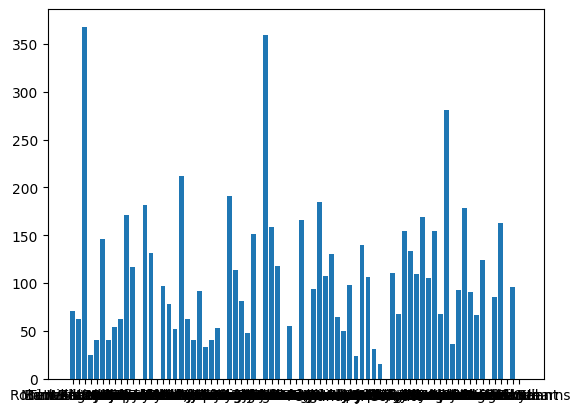

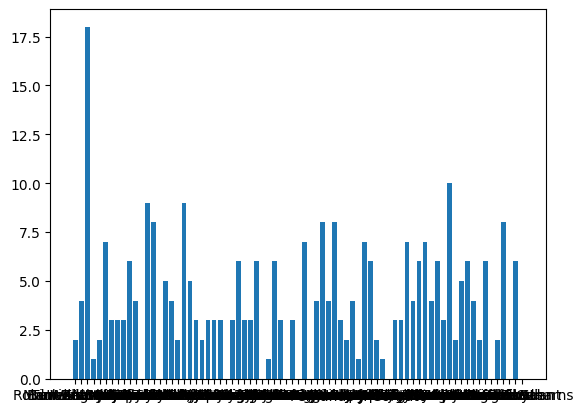

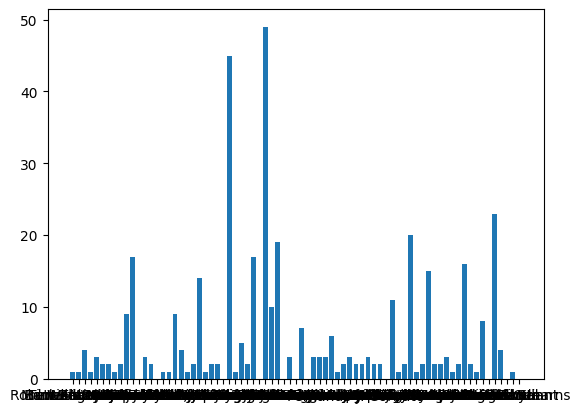

In [15]:
# Plots bar charts with the recipient names on the x-axis and the statistics
# on the y-axis. The question does not tell me to fix the labels as that is
# task 14, so each of the bar chart labels looks very messy and unreadable.
plot1 = figure()
bar(award_winners_intro["winner_name"], award_winners_intro["count_words"])

plot2 = figure()
bar(award_winners_intro["winner_name"], award_winners_intro["count_sentences"])

plot3 = figure()
bar(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"])

## Task 12

![alt text](task12.png "Task 12")

C:\Users\Daniel\AppData\Local\Temp\ipykernel_58816\1498489037.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


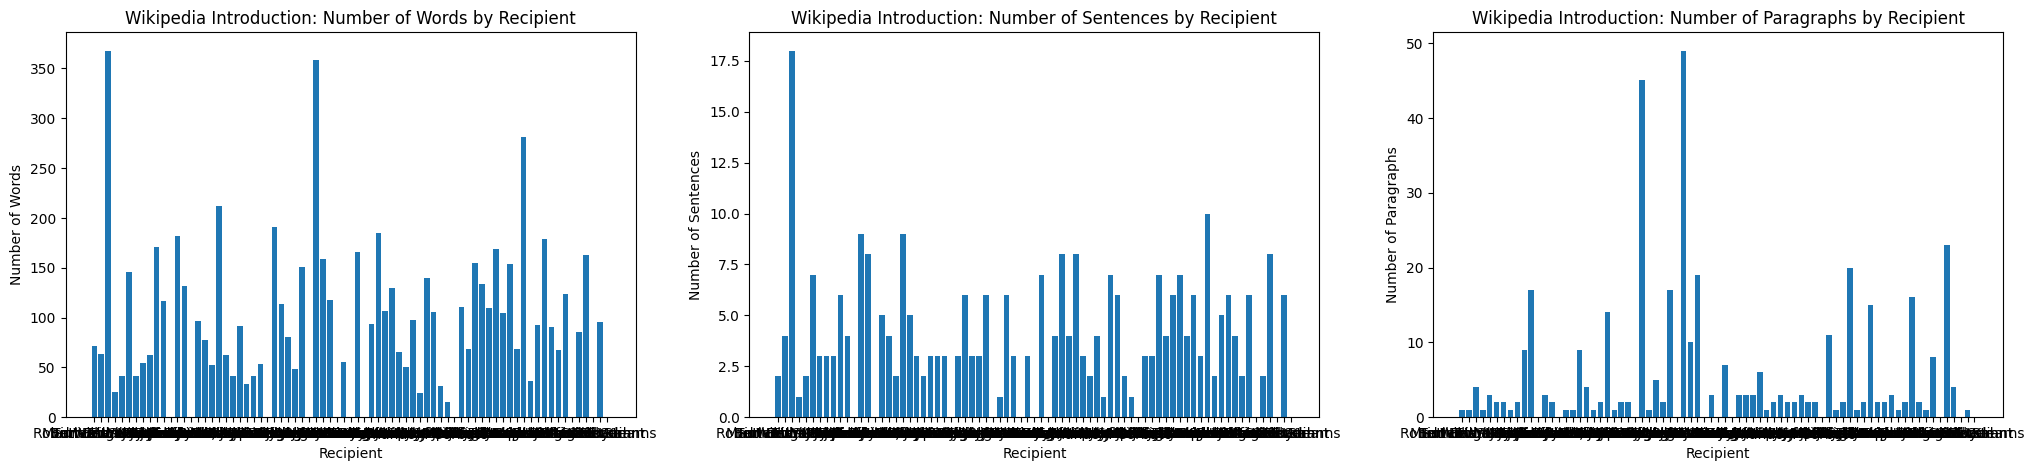

In [16]:
# The 3 bar charts from Task 11 in one subplot. Once again, I have not fixed the
# the chart labels as this is task 14, so once again it looks very messy and 
# unreadable.

# Creates a subfigure with 1 row and 3 columns (space for 3 graphs).
fig, (axis1, axis2, axis3) = subplots(1, 3, figsize=(25,5))

# Plots bar charts with the recipient names on the x-axis and the statistics
# on the y-axis.
axis1.bar(award_winners_intro["winner_name"],
          award_winners_intro["count_words"])
axis1.set_title("Wikipedia Introduction: Number of Words by Recipient")
axis1.set_ylabel("Number of Words")
axis1.set_xlabel("Recipient")

axis2.bar(award_winners_intro["winner_name"],
          award_winners_intro["count_sentences"])
axis2.set_title("Wikipedia Introduction: Number of Sentences by Recipient")
axis2.set_ylabel("Number of Sentences")
axis2.set_xlabel("Recipient")

axis3.bar(award_winners_intro["winner_name"],
          award_winners_intro["count_paragraphs"])
axis3.set_title("Wikipedia Introduction: Number of Paragraphs by Recipient")
axis3.set_ylabel("Number of Paragraphs")
axis3.set_xlabel("Recipient")

fig.show()

## Task 13

![alt text](task13.png "Task 13")

C:\Users\Daniel\AppData\Local\Temp\ipykernel_58816\3121953371.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


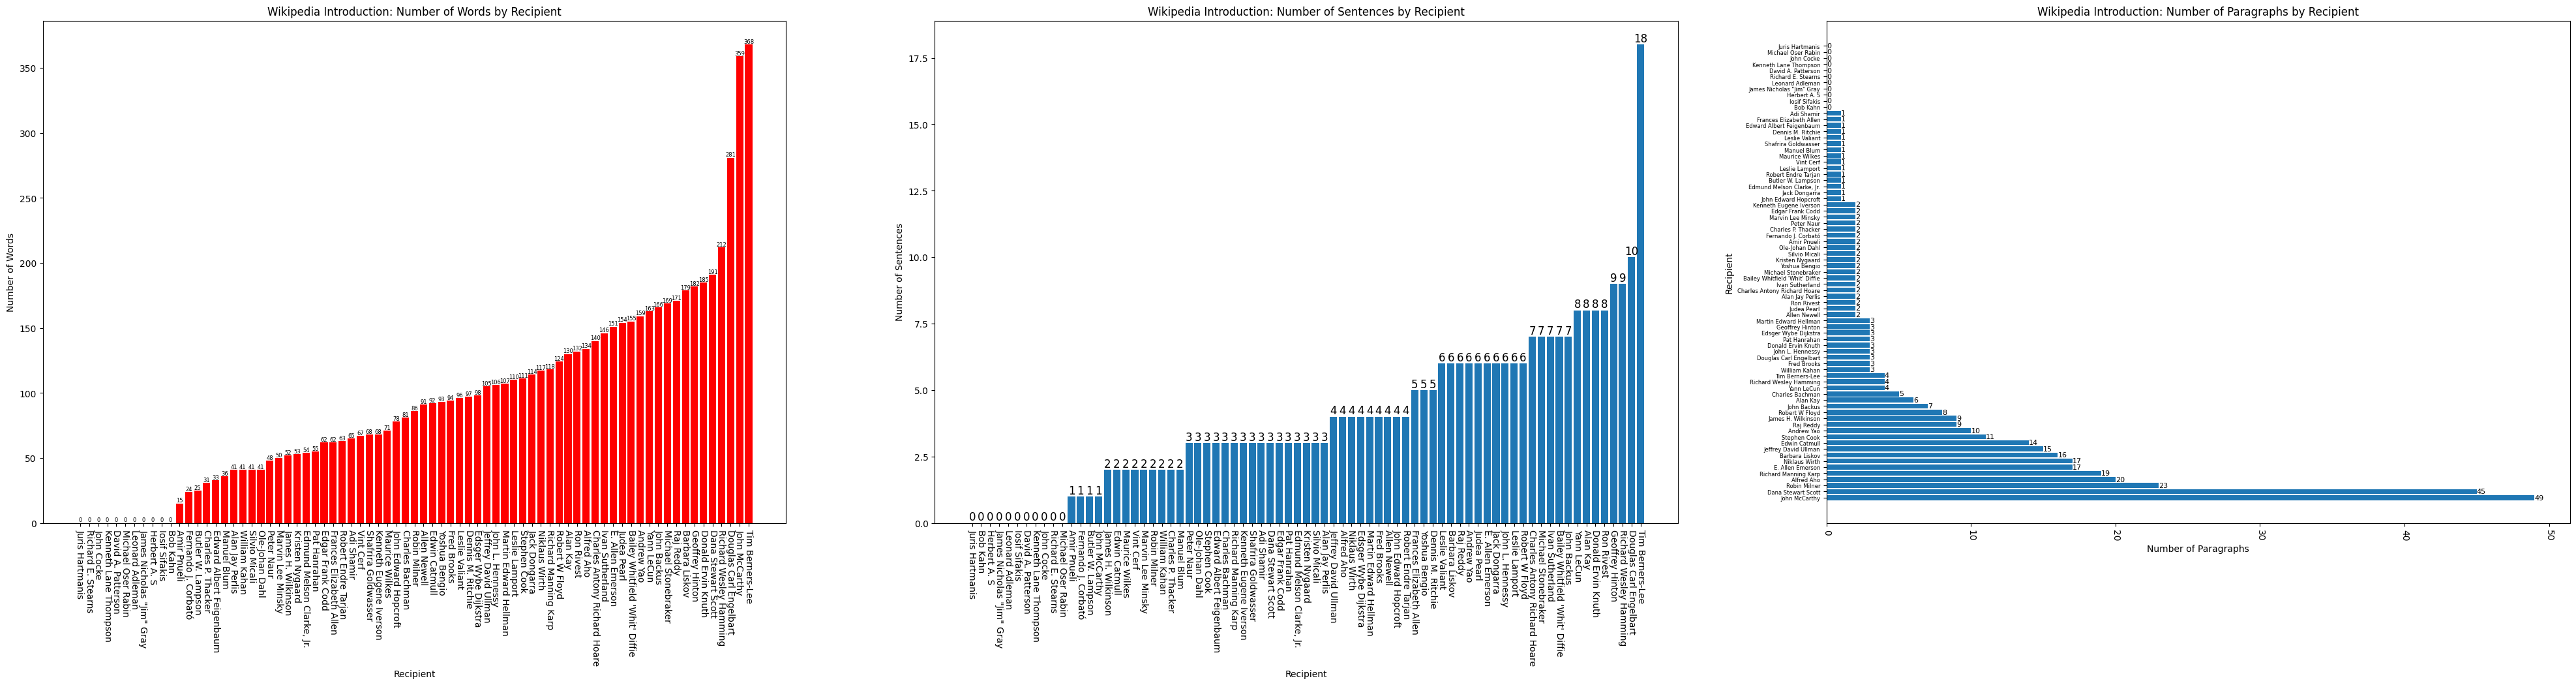

In [17]:
# Creates a subfigure with 1 row and 3 columns (space for 3 graphs).
fig, (axis1, axis2, axis3) = subplots(1, 3, figsize=(50,10))

intros_sorted = award_winners_intro.copy()
# Sorts each dataframe by a column before plotting it as a bar chart with
# recipient names on the x-axis and statistics on the y-axis.
intros_sorted = intros_sorted.sort_values(by=["count_words"])
bars1 = axis1.bar(intros_sorted["winner_name"],
                  intros_sorted["count_words"], color="r")

intros_sorted = intros_sorted.sort_values(by=["count_sentences"])
bars2 = axis2.bar(intros_sorted["winner_name"],
                  intros_sorted["count_sentences"])

intros_sorted = intros_sorted.sort_values(by=["count_paragraphs"],
                                          ascending=False)
bars3 = axis3.barh(intros_sorted["winner_name"],
                   intros_sorted["count_paragraphs"])

# Rotates and changes size of x and y axis labels so that they are readable.
axis1.tick_params(axis="x", rotation=270, labelsize=10)
axis2.tick_params(axis="x", rotation=270, labelsize=10)
axis3.tick_params(axis="x", rotation=270)
axis3.tick_params(axis="y", labelsize=6)

# Changes the size of the "exact count" labels at the top of each bar so that 
# they do not overlap.
axis1.bar_label(bars1, size=6)
axis2.bar_label(bars2, size=12)
axis3.bar_label(bars3, size=8)

# Neatens each of the plots by adding titles and axis titles.
axis1.set_title("Wikipedia Introduction: Number of Words by Recipient")
axis1.set_ylabel("Number of Words")
axis1.set_xlabel("Recipient")

axis2.set_title("Wikipedia Introduction: Number of Sentences by Recipient")
axis2.set_ylabel("Number of Sentences")
axis2.set_xlabel("Recipient")

axis3.set_title("Wikipedia Introduction: Number of Paragraphs by Recipient")
axis3.set_ylabel("Recipient")
axis3.set_xlabel("Number of Paragraphs")

fig.show()

# 3.3.2 Heatmap

## Task 14 (c)

![alt text](task14.png "Task 14")

## Task 14 (a) and (b)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_58816\2886757745.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot1.show()


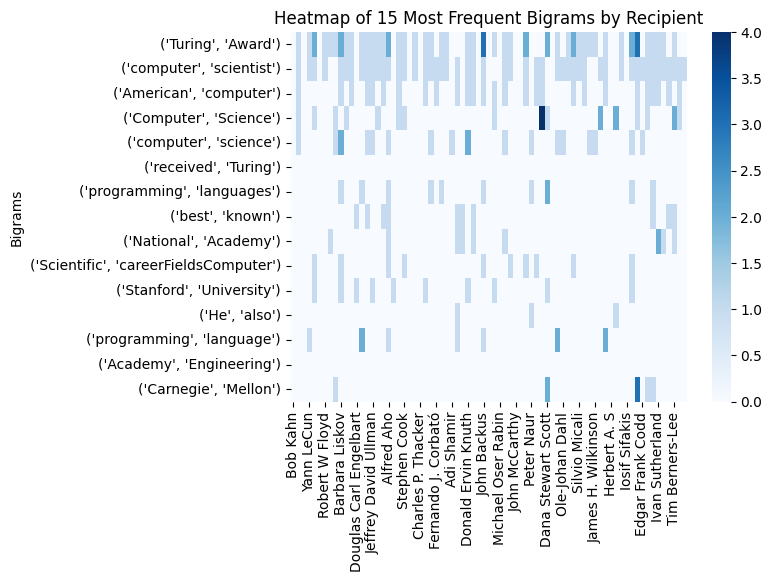

In [18]:
# Note: although the specification states to only use "the Python package
# matplotlib" I have used seaborn, which extends matplotlib, and was allowed
# here: https://keats.kcl.ac.uk/mod/forum/discuss.php?d=550237
#

# List of the 15 most used bigrams.
most_used_bigrams = list(sorted_winner_bigrams.keys())[:15]
# Declares the "bigrams_winners" DataFrame with a single column "Bigrams" with
# each row's value being one of the 15 most used bigrams.
bigrams_winners = DataFrame({"Bigrams": most_used_bigrams})
counter = 0
for intro in tokenized_intros:  # For each tokenized introduction.
    # Calculates the frequency of each bigram in the current "intro".
    bigrams_dist = FreqDist(bigrams(intro))
    bigrams_freq = []
    for bigram in most_used_bigrams:  # For each of the 15 most used bigrams.
        # If this bigram is present in the current introduction.
        if bigram in bigrams_dist.keys():  
            # Append said bigrams frequency to "bigrams_freq".
            bigrams_freq.append(bigrams_dist[bigram])
        # Else, if the bigram is not in the current "intro", append 0.
        else: bigrams_freq.append(0)
    # Insert a new column, with the column's name being the current recipients
    # name, and with each row's value being the frequency of said bigram in the
    # current "intro".        
    bigrams_winners.insert(1, award_winners["name"][counter], bigrams_freq)
    counter += 1

# Sets the index column as the "Bigrams" column so as to plot a heatmap with
# this column on the y-axis.
bigrams_winners.set_index("Bigrams", inplace=True)
# Plots the heatmap from the "bigrams_winners" DataFrame.
plot1 = figure()
heatmap(bigrams_winners, cmap="Blues")
plot1.gca().set_title('Heatmap of 15 Most Frequent Bigrams by Recipient')
# plot1.ylabel('Recipient')
plot1.show()